# 1. Import

In [201]:
# Basic Library
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

In [202]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [203]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [204]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory :", dir)
    else:
        print("Directory already existed :", dir)
create_dir("../pickle")
create_dir("../model")
create_dir("../submission")

Directory already existed : ../pickle
Directory already existed : ../model
Directory already existed : ../submission


In [205]:
train.dtypes

Gender             object
Lenght            float64
Diameter          float64
Height            float64
Whole Weight      float64
Shucked Weight    float64
Viscra Weight     float64
Shell Weight      float64
Target              int64
dtype: object

In [298]:
rows_train = train.shape[0] # 주어진 train data의 row 수
rows_test = test.shape[0] # 주어진 test data의 row 수
num_trial = 20 # 파라미터 튜닝을 몇 번 진행하는지의 수
splits_hp = 10 # 파라미터 튜닝을 진행할 때의 kfold 수
splits_tr = 15 # 모델 트레이닝을 진행할 때의 kfold 수
basic_seed = 42 # default seed
num_seed = 10 # 트레이닝 seed 개수
sel_seed = 3 # 선택할 seed 개수

# 2. Data Preprocessing

In [207]:
train_lab = train.copy()
test_lab = test.copy()

enc = LabelEncoder()
for col in train_lab.columns:
    if train_lab[col].dtypes=='object':
        train_lab[col] = enc.fit_transform(train_lab[col])
        test_lab[col] = enc.fit_transform(test_lab[col])

train_x = train_lab.drop(['Target'], axis=1) # 데이터 나누기
train_y = train_lab['Target']
test_x = test_lab.copy()

print('Label Encoding Completed')

Label Encoding Completed


# 3. Modeling

## (1) LightGBM

In [353]:
def lgb_objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": basic_seed,
        "verbosity": -1,
        "n_estimators": 10000,
        'learning_rate': trial.suggest_uniform("learning_rate", 0.001, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
#         "reg_alpha": trial.suggest_uniform("reg_alpha", 0.0, 0.5),
#         "reg_lambda": trial.suggest_uniform("reg_lambda", 0.0, 0.5),
         "num_leaves": trial.suggest_int("num_leaves", 31, 500),
#         "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0), # feature_fraction
#         "subsample": trial.suggest_uniform("subsample", 0.1, 1.0),
#         "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
#         "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
#         "max_bin": trial.suggest_int("max_bin", 150, 400),
    }
    
    kfold = StratifiedKFold(n_splits=splits_hp, random_state=basic_seed, shuffle=True) # Cross-validation cv=5
    cv = np.zeros(rows_train)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values, train_y.iloc[val_idx].values

        lgbmodel = LGBMRegressor(**params_lgb)
                                                                                        # 진행상황 보고싶을때 -1을 100으로
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=10, verbose=-1) 
        cv[val_idx] = lgbmodel.predict(x_val)
        
    print('MAE:', mean_absolute_error(train_y, cv))
    return mean_absolute_error(train_y, cv)

In [354]:
sampler = TPESampler(seed=basic_seed)
lgb_study = optuna.create_study(study_name="lgb_parameter_opt", direction="minimize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=num_trial)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'n_estimators':10000,
#                         'lambda_l1':lgb_best_hyperparams['reg_alpha'],
#                         'lambda_l2':lgb_best_hyperparams['reg_lambda']
                       }
lgb_best_hyperparams.update(lgb_base_hyperparams)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

[I 2022-03-21 12:26:53,690] A new study created in memory with name: lgb_parameter_opt
[I 2022-03-21 12:26:54,313] Trial 0 finished with value: 1.5680543880703386 and parameters: {'learning_rate': 0.03807947176588889, 'max_depth': 6, 'num_leaves': 375}. Best is trial 0 with value: 1.5680543880703386.


MAE: 1.5680543880703386


[I 2022-03-21 12:26:54,641] Trial 1 finished with value: 1.5876377427418018 and parameters: {'learning_rate': 0.06026718993550663, 'max_depth': 3, 'num_leaves': 104}. Best is trial 0 with value: 1.5680543880703386.


MAE: 1.5876377427418018


[I 2022-03-21 12:26:57,347] Trial 2 finished with value: 1.5693071534431322 and parameters: {'learning_rate': 0.006750277604651747, 'max_depth': 6, 'num_leaves': 313}. Best is trial 0 with value: 1.5680543880703386.


MAE: 1.5693071534431322


[I 2022-03-21 12:26:57,705] Trial 3 finished with value: 1.5822098109614693 and parameters: {'learning_rate': 0.07109918520180851, 'max_depth': 3, 'num_leaves': 486}. Best is trial 0 with value: 1.5680543880703386.


MAE: 1.5822098109614693


[I 2022-03-21 12:26:58,072] Trial 4 finished with value: 1.5827459958112535 and parameters: {'learning_rate': 0.08341182143924175, 'max_depth': 3, 'num_leaves': 116}. Best is trial 0 with value: 1.5680543880703386.


MAE: 1.5827459958112535


[I 2022-03-21 12:26:59,021] Trial 5 finished with value: 1.5719575679994189 and parameters: {'learning_rate': 0.01915704647548995, 'max_depth': 4, 'num_leaves': 277}. Best is trial 0 with value: 1.5680543880703386.


MAE: 1.5719575679994189


[I 2022-03-21 12:26:59,553] Trial 6 finished with value: 1.5722425226407246 and parameters: {'learning_rate': 0.04376255684556946, 'max_depth': 4, 'num_leaves': 318}. Best is trial 0 with value: 1.5680543880703386.


MAE: 1.5722425226407246


[I 2022-03-21 12:27:00,857] Trial 7 finished with value: 1.5712197100206562 and parameters: {'learning_rate': 0.01480989220455214, 'max_depth': 4, 'num_leaves': 203}. Best is trial 0 with value: 1.5680543880703386.


MAE: 1.5712197100206562


[I 2022-03-21 12:27:01,661] Trial 8 finished with value: 1.5652644053710962 and parameters: {'learning_rate': 0.04615092843748656, 'max_depth': 6, 'num_leaves': 124}. Best is trial 8 with value: 1.5652644053710962.


MAE: 1.5652644053710962


[I 2022-03-21 12:27:02,204] Trial 9 finished with value: 1.5652104760698937 and parameters: {'learning_rate': 0.051909209402947555, 'max_depth': 5, 'num_leaves': 52}. Best is trial 9 with value: 1.5652104760698937.


MAE: 1.5652104760698937


[I 2022-03-21 12:27:02,575] Trial 10 finished with value: 1.5716132947092973 and parameters: {'learning_rate': 0.09456851787880828, 'max_depth': 5, 'num_leaves': 34}. Best is trial 9 with value: 1.5652104760698937.


MAE: 1.5716132947092973


[I 2022-03-21 12:27:03,288] Trial 11 finished with value: 1.567781513333312 and parameters: {'learning_rate': 0.035338238249255575, 'max_depth': 5, 'num_leaves': 164}. Best is trial 9 with value: 1.5652104760698937.


MAE: 1.567781513333312


[I 2022-03-21 12:27:03,856] Trial 12 finished with value: 1.5659736484590825 and parameters: {'learning_rate': 0.05840526177104801, 'max_depth': 6, 'num_leaves': 49}. Best is trial 9 with value: 1.5652104760698937.


MAE: 1.5659736484590825


[I 2022-03-21 12:27:04,361] Trial 13 finished with value: 1.561268008691888 and parameters: {'learning_rate': 0.051714576363635446, 'max_depth': 5, 'num_leaves': 198}. Best is trial 13 with value: 1.561268008691888.


MAE: 1.561268008691888


[I 2022-03-21 12:27:04,823] Trial 14 finished with value: 1.5658607708257255 and parameters: {'learning_rate': 0.07123933358570064, 'max_depth': 5, 'num_leaves': 191}. Best is trial 13 with value: 1.561268008691888.


MAE: 1.5658607708257255


[I 2022-03-21 12:27:05,799] Trial 15 finished with value: 1.5635548910620882 and parameters: {'learning_rate': 0.027601432165172437, 'max_depth': 5, 'num_leaves': 238}. Best is trial 13 with value: 1.561268008691888.


MAE: 1.5635548910620882


[I 2022-03-21 12:27:06,711] Trial 16 finished with value: 1.5623862594711786 and parameters: {'learning_rate': 0.027432116221591595, 'max_depth': 5, 'num_leaves': 241}. Best is trial 13 with value: 1.561268008691888.


MAE: 1.5623862594711786


[I 2022-03-21 12:27:07,437] Trial 17 finished with value: 1.571029084421453 and parameters: {'learning_rate': 0.024839985812590105, 'max_depth': 4, 'num_leaves': 402}. Best is trial 13 with value: 1.561268008691888.


MAE: 1.571029084421453


[I 2022-03-21 12:27:11,547] Trial 18 finished with value: 1.565987797658077 and parameters: {'learning_rate': 0.004955715250860696, 'max_depth': 5, 'num_leaves': 244}. Best is trial 13 with value: 1.561268008691888.


MAE: 1.565987797658077


[I 2022-03-21 12:27:12,256] Trial 19 finished with value: 1.5701513394016802 and parameters: {'learning_rate': 0.03035018068620994, 'max_depth': 4, 'num_leaves': 368}. Best is trial 13 with value: 1.561268008691888.


MAE: 1.5701513394016802
The best hyperparameters are:
 {'learning_rate': 0.051714576363635446, 'max_depth': 5, 'num_leaves': 198, 'n_estimators': 10000}


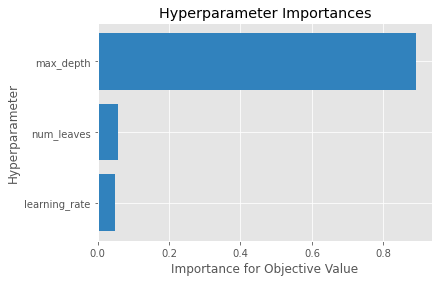

In [355]:
optuna.visualization.matplotlib.plot_param_importances(lgb_study);

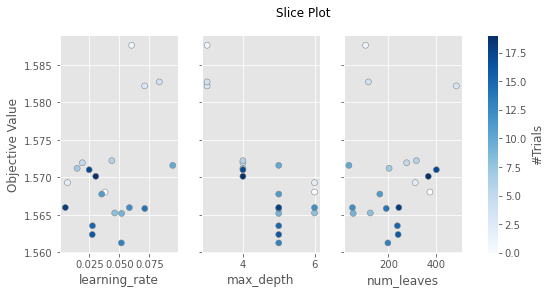

In [356]:
optuna.visualization.matplotlib.plot_slice(lgb_study);

In [357]:
base_typerparameters = {'learning_rate': 0.051714576363635446, 'max_depth': 5, 'num_leaves': 198, 'n_estimators': 10000}

In [333]:
base_typerparameters = {'learning_rate': 0.1, 'max_depth': 3, 'verbose': 3, 'force_row_wise': True}

In [265]:
base_typerparameters = {'learning_rate': 0.0070415096943982226, 'reg_alpha': 0.206432032989424, 'reg_lambda': 0.29807975059531805, 'max_depth': 6, 'num_leaves': 784, 'colsample_bytree': 0.7790230196623364, 'subsample': 0.3434138185587682, 'max_bin': 306}

In [303]:
base_typerparameters = {'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 300, 
                        'colsample_bytree': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'random_state': 42}

In [311]:
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=.1, random_state=42)

In [358]:
lgbmodel = LGBMRegressor(**base_typerparameters)
lgbmodel.fit(x_train, y_train)
print("Model1 Score: ",lgbmodel.score(x_val,y_val))
print("MAE:",mean_absolute_error(y_val, lgbmodel.predict(x_val)))

Model1 Score:  0.44542147656707853
MAE: 1.6564224310720335


In [288]:
pred = lgbmodel.predict(test_x)

In [322]:
pred

array([ 8.43842509, 12.74286492,  5.56701004, ...,  9.71357325,
        9.23734618, 11.08841116])

In [290]:
submission.Target = pred

In [292]:
submission_name = '20220321'
submission_number = '2'
submission.to_csv(f'../submission/{submission_name}-{submission_number}.csv', index = False)